In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import pandas as pd
import time
from numba import njit
from scipy.integrate import quad

In [5]:
k_a = 1 #1.380649e-34 # Constante de Boltzman
J = 1.0
iteraciones = 100*50
T0= 130 # Temperatura incial
k= 0.9  # Constante de reducción

In [6]:
def init(N):
  return np.random.choice([-1, 1], size=(N, N))

In [7]:
critic_temperature = 2*J / np.log(1 + np.sqrt(2))
critic_temperature

np.float64(2.269185314213022)

--------------------------------

## Ising

In [5]:
@njit
def delta_energia(i, j, P0, N, h):
  x0 = P0.copy()
  i = i % N
  j = j % N
  ip = (i + 1) % N
  im = (i - 1) % N
  jp = (j + 1) % N
  jm = (j - 1) % N

  delta = (2 * J * x0[i, j] * (x0[ip, j]
          + x0[im, j] + x0[i, jp]
          + x0[i, jm])) + 2 * h * x0[i, j]

  return delta


In [6]:
@njit
def energy_per_site(p0, J, N, h):
  energy = 0
  for i in range(N):
      for j in range(N):
          ip = (i + 1) % N
          jp = (j + 1) % N
          c = p0[i, j] * (p0[ip, j] + p0[i, jp])
          energy += -J * c + h * p0[i, j]
  energy_per_site = energy / N**2
  return energy_per_site

In [7]:
@njit
def magentization_per_spin(p0, N):
    return np.sum(p0) / (N ** 2)

--------------------

## Heuristico

In [8]:
@njit
def metropolis_one_step(x0, beta, N, h):
  """Realiza un paso de Metropolis en el sistema"""
  x0_old = x0.copy()
  i, j=np.random.randint(0, N, size=2)




  delta_E=delta_energia(i, j, x0, N, h)


  u=np.random.rand()

  if delta_E<= 0 or  np.exp(-beta*delta_E) >= u:
      x0[i, j]*=-1







  return x0

In [9]:
@njit
def metropolis_total(x0, iteraciones, beta, J, N, h, tol=1e-4):

    energia_history = np.zeros(iteraciones)
    magnet_history = np.zeros(iteraciones)
    x_current = x0.copy()

    for i in range(0, iteraciones):
        x_old = x_current.copy()
        x_current = metropolis_one_step(x_old, beta, N, h)

        energia_history[i] = energy_per_site(x_current, J, N, h)
        magnet_history[i] = magentization_per_spin(x_current, N)

        if i > 100 and i % 100 == 0:

            recent_E = energia_history[i-100:i]
            recent_M = magnet_history[i-100:i]

            sigma_E = np.std(recent_E)
            sigma_M = np.std(recent_M)

            if sigma_E < tol and sigma_M < tol:
                break


    energia_history = energia_history[:i+1]
    magnet_history = magnet_history[:i+1]

    return x_current, energia_history[-1], i

In [10]:
@njit
def metropolis_total_T(x0, iteraciones, Temperature, J, N, h, tol=1e-4):

    n_temps = len(Temperature)
    energy = np.zeros(n_temps)
    magnetization = np.zeros(n_temps)
    iter_t = np.zeros(n_temps, dtype=np.int32)

    current_config = x0.copy()

    for idx, temp in enumerate(Temperature):
        beta = 1 / (k_a * temp)


        current_config, energy_pe, iters = metropolis_total(
            current_config, iteraciones, beta, J, N, h, tol)

        energy[idx] = energy_per_site(current_config, J, N, h)
        magnetization[idx] = magentization_per_spin(current_config, N)
        iter_t[idx] = iters

    return current_config, energy, magnetization, iter_t

---------------------

### Metahuristico

In [11]:
@njit
def reduce_temperature(actual_temperature, factor_k):
    """Reduce la temperatura del sistema"""
    return actual_temperature * factor_k

In [12]:
@njit
def metropolis_probability(delta_energy,
                          actual_temperature):
  """Calcula la probabilidad de aceptación de la nueva solución"""
  if actual_temperature == 0:
    return 0
  return np.exp(-delta_energy / (actual_temperature * k_a))

In [13]:
@njit
def simulated_annealing_1_step(p0, initial_temperature, N, h):
  """Realiza el método de simulated annealing para una iteracion"""
  actual_temperature = initial_temperature

  p0 = p0.copy()
  i, j = np.random.randint(0, N, size=2)
  delta_energy = delta_energia(i, j, p0, N, h)



  metropolis= metropolis_probability(delta_energy,
                                                 actual_temperature
                                                 )
  u = np.random.rand()
  if delta_energy <= 0 or metropolis >= u:
      p0[i, j] *= -1



  return p0

In [14]:
@njit
def ising_all_system_const(p0, temperature, iteraciones, sub_iteraciones, J, N, h, tol=1e-4):
    iteraciones = np.int32(iteraciones)
    sub_iteraciones = np.int32(sub_iteraciones)
    tol = np.float64(tol)

    energia = np.zeros(iteraciones, dtype=np.float64)
    magnetizacion = np.zeros(iteraciones, dtype=np.float64)
    converged_iter = np.int32(0)
    p_current = p0.copy()
    final_iter = iteraciones


    for i in range(iteraciones):
        current_temp = temperature[i]

        for _ in range(sub_iteraciones):
            p_current = simulated_annealing_1_step(p_current, current_temp, N, h)

        energia[i] = energy_per_site(p_current, J, N, h)
        magnetizacion[i] = magentization_per_spin(p_current, N)

        if i > 0:
            delta_E = np.abs(energia[i] - energia[i-1]) / max(np.abs(energia[i]), 1e-10)
            delta_M = np.abs(magnetizacion[i] - magnetizacion[i-1]) / max(np.abs(magnetizacion[i]), 1e-10)

            if delta_E < tol and delta_M < tol:
                converged_iter += 1
                if converged_iter >= 10:
                    final_iter = i + 1
                    break
            else:
                converged_iter = 0

    return p_current, energia[:final_iter], magnetizacion[:final_iter], final_iter - 1

In [15]:
def get_temperature(iteraciones, T0, k):
  temperature = np.array([])
  for _ in range(iteraciones):
    temperature = np.append(temperature, T0)
    T0 = reduce_temperature(T0, k)
  return temperature

----------------------

### Valores teoricos reales *(solucion onsager)*

--------------------------

### Energía por sitio

In [16]:
# Valor téorico de la energia:
def integrand(theta, k):
  return 1 / np.sqrt(1 - 4 * k * (1 + k)**(-2) * np.sin(theta)**2)

def real_value_energy(T):
  if T<1e-1:
    return -2* J
  else:
    beta = 1 / (k_a * T)
    k= 1/ (np.sinh(2* beta* J)**2)
    U = -J * (np.cosh(2*J*beta) / np.sinh(2*J*beta))
    integral = quad(integrand, 0, np.pi/2, args=(k,))[0]
    U *= 1 + (2 / np.pi) * (2 * (np.tanh(2 * beta * J))** 2 - 1) * integral
  return U

### Magnetización

In [13]:
def real_magnetization(beta):
  print(k_a, critic_temperature, J)  
  if 1 / (k_a * beta) < critic_temperature:
    print("k")
    arg = 2 * beta * J
    if arg > 700:
        M= 1
    sinh_arg = np.sinh(arg)
    M = (1 - (sinh_arg ** -4)) ** (1/8)

  else:
    M = 0
  return M

In [14]:
real_magnetization(1 /k_a*critic_temperature)

1 2.269185314213022 1.0
k


np.float64(0.9999999738620627)

-----------

## Prueba de Algoritmos

In [18]:
N = 70
p0 = init(N)
iteraciones = 100*500

In [19]:
# Heuristico T=0.01
p0_final_h_1, energia_h_1, iter_h1 = metropolis_total(p0, iteraciones= iteraciones, beta=1/0.01, J= J, N=N, h = 0)

In [20]:
# Heuristico T=10
p0_final_h_2, energia_h_2, inter_h2 = metropolis_total(p0, iteraciones= iteraciones, beta=1/10, J=J,N=N, h = 0)

In [21]:
# Metaheuristico
temperature = get_temperature(iteraciones= iteraciones, T0= T0, k= k)
p0_final_meta, energy_metaheuristic, magnetizacion_metaheuristic, iter_meta = ising_all_system_const(p0, temperature = temperature, iteraciones= iteraciones, sub_iteraciones=300,J=J, N=N, h = 0, tol= 1e-5)


In [22]:
final_temperature = get_temperature(iteraciones= iteraciones, T0=T0, k=k)[-1]

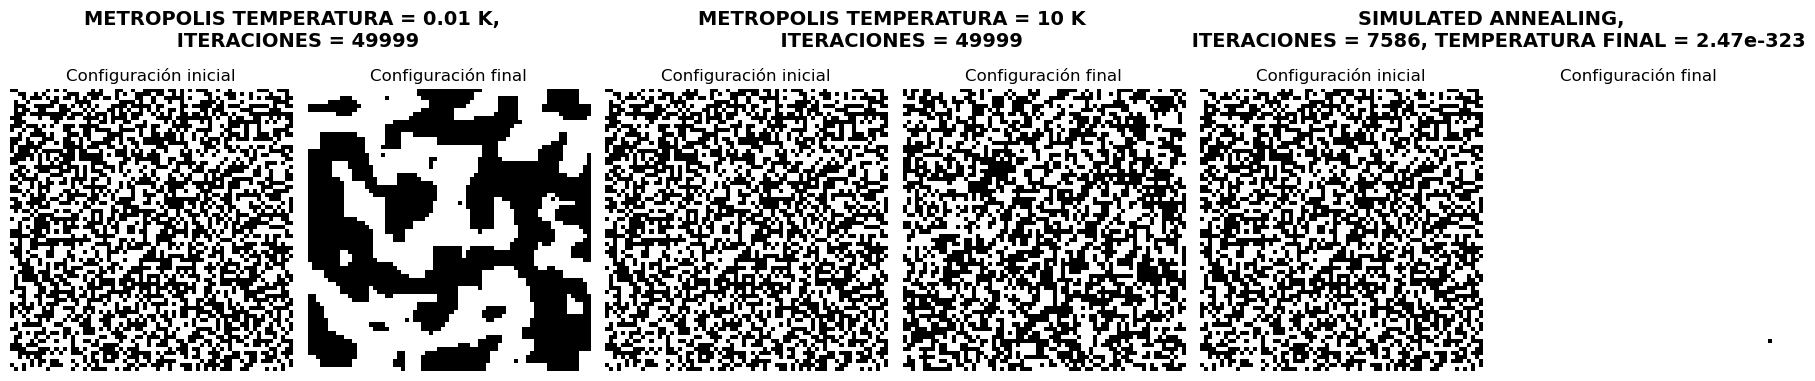

In [23]:
p0_final = [p0_final_h_1, p0_final_h_2, p0_final_meta]
encabezados = [f"METROPOLIS TEMPERATURA = 0.01 K, \n ITERACIONES = {iter_h1}",
               f"METROPOLIS TEMPERATURA = 10 K \n  ITERACIONES = {inter_h2}",
               f"SIMULATED ANNEALING, \n ITERACIONES = {iter_meta}, TEMPERATURA FINAL = {final_temperature:.2e}"]

fig, axes = plt.subplots(1, 6, figsize=(18, 5))  # 1 fila, 6 columnas

for i in range(3):
    idx = i * 2
    axes[idx].imshow(p0, cmap='gray')
    axes[idx].set_title('Configuración inicial')
    axes[idx].axis('off')  # Opcional: ocultar ejes

    axes[idx + 1].imshow(p0_final[i], cmap='gray')
    axes[idx + 1].set_title('Configuración final')
    axes[idx + 1].axis('off')

    # Añadir encabezado centrado sobre ambas imágenes
    fig.text((idx + 1) / 6, 0.9, encabezados[i], ha='center', va='center',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("Comparacion_Algoritmos_horizontal_.jpeg", bbox_inches='tight')
plt.show()

## Valores reales

In [75]:
final_energy_simulated = energy_metaheuristic[-1]

In [76]:
real_energy_heuristic_h1 = real_value_energy(0.01)
real_energy_heuristic_h2 = real_value_energy(10)

In [77]:
real_energy_metaheuristic_ = -2* J

In [78]:
energias = {"Energía  por sitio teórica":[round(real_energy_heuristic_h1, 2), round(real_energy_heuristic_h2, 2), real_energy_metaheuristic_], "Energía por sitio calculada": [energia_h_1, energia_h_2, final_energy_simulated]}
energias = pd.DataFrame(energias, index=["Heuristica T=0.01 K", "Heuristica T=10 K", "Metaheurística"])
print(energias)

                     Energía  por sitio teórica  Energía por sitio calculada
Heuristica T=0.01 K                        -2.0                    -1.648980
Heuristica T=10 K                          -0.2                    -0.200816
Metaheurística                             -2.0                    -2.000000


-----------

------------------

## Energia por sitio

In [48]:
iteraciones = 100*400
h = 1e-7

In [37]:
temperature = get_temperature(iteraciones= iteraciones, T0= T0, k = k)
temperature_heu = np.arange(1, 4, 0.1)

In [49]:
N = 20 
p0 = init(N)

In [50]:

p0_final_meta3, energy_metaheuristic3, magnetizacion_metaheuristic3, iter_meta3 = ising_all_system_const(p0,
                                                                                                       temperature = temperature,
                                                                                                       iteraciones= iteraciones, sub_iteraciones=100*200, J= J, N=N, h = h, tol= 1e-4)



In [30]:
i = 100*500
p0_final_heu_3, energy_heuristic_T3, magnetizacion_heur3, _ = metropolis_total_T(p0, iteraciones=i,
                                                                       Temperature= temperature_heu,
                        
                                                                                 J=J, N=N,h =h, tol= 1e-4)

In [51]:
N =70
p0 = init(N)

In [52]:

p0_final_meta1, energy_metaheuristic1, magnetizacion_metaheuristic1, iter_meta1 = ising_all_system_const(p0 = p0, temperature = temperature, iteraciones= iteraciones, sub_iteraciones=600*2000, J= J, N= N, h= h, tol= 1e-4)


In [33]:
i =200*500
p0_final_heu_1, energy_heuristic_T1, magnetizacion_heur1, _ = metropolis_total_T(p0, iteraciones=i,
                                                                       Temperature= temperature_heu,
                                                                       J=J, N=N, h= h, tol= 1e-4)

In [53]:
N = 110
p0 = init(N)
i = 200*500

In [54]:

p0_final_meta2, energy_metaheuristic2, magnetizacion_metaheuristic2, iter_meta2 = ising_all_system_const(p0,
                                                                                                       temperature = temperature,
                                                                                                       iteraciones= iteraciones, sub_iteraciones=1000*4000, J= J, N=N, h= h, tol= 1e-4)




In [35]:
p0_final_heu_2, energy_heuristic_T2, magnetizacion_heur2, _ = metropolis_total_T(p0, iteraciones=i,
                                                                       Temperature= temperature_heu,
                                                                       J=J, N=N, h= h, tol= 1e-4)

In [44]:
real_energy_metaheuristic= [real_value_energy(i) for i in temperature]
real_energy_heuristic= [real_value_energy(i) for i in temperature_heu]


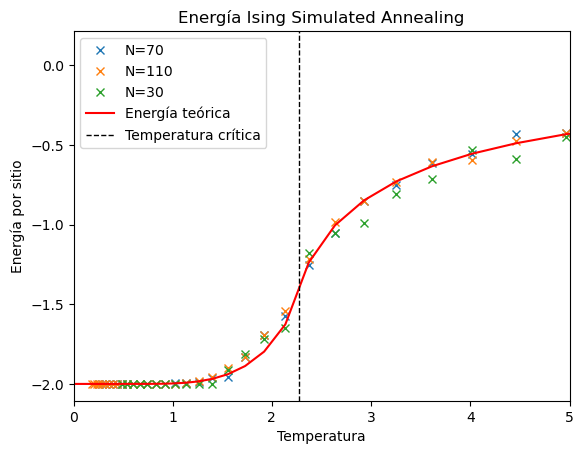

In [45]:
plt.plot(temperature[:iter_meta1+1], energy_metaheuristic1, "x", label = "N=70")
plt.plot(temperature[:iter_meta2+1], energy_metaheuristic2, "x", label = "N=110")
plt.plot(temperature[:iter_meta3+1], energy_metaheuristic3, "x", label = "N=30")
plt.plot(temperature, real_energy_metaheuristic,  "-r", label = "Energía teórica")
plt.axvline(critic_temperature, ls = "--", c="k", lw = 1.,label ="Temperatura crítica")
plt.xlabel("Temperatura")
plt.ylabel("Energía por sitio")
plt.title("Energía Ising Simulated Annealing")
plt.xlim(0,5)
plt.legend()
plt.savefig("Energaia meta.jpeg")

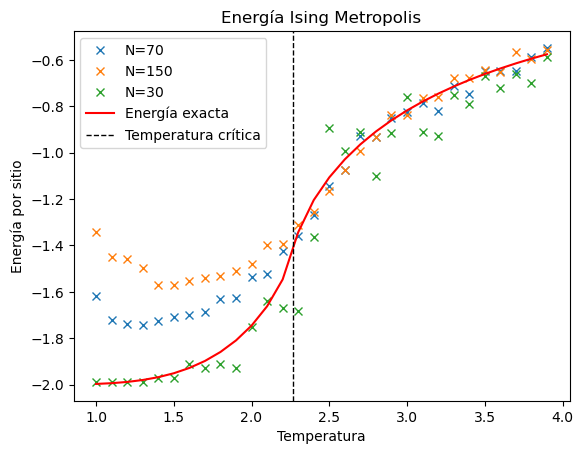

In [55]:
plt.plot(temperature_heu, energy_heuristic_T1, "x", label = "N=70")
plt.plot(temperature_heu, energy_heuristic_T2, "x", label = "N=150")
plt.plot(temperature_heu, energy_heuristic_T3, "x", label = "N=30")
plt.plot(temperature_heu, real_energy_heuristic,  "-r", label = "Energía exacta")
plt.title("Energía Ising Metropolis")
plt.xlabel("Temperatura")
plt.ylabel("Energía por sitio")
plt.axvline(critic_temperature, ls = "--", c="k",lw = 1., label ="Temperatura crítica")

plt.legend()
plt.savefig("energia heuristico.jpeg")

NameError: name 'p0_final_heu_1' is not defined

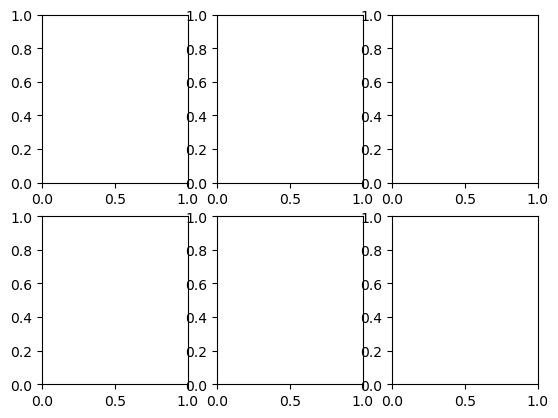

In [29]:
f, axarr = plt.subplots(2, 3)

axarr[0,0].imshow(p0_final_heu_1, cmap='gray')
axarr[0,0].set_title("Heurístico N=70")

axarr[0,1].imshow(p0_final_heu_2, cmap='gray')
axarr[0,1].set_title("Heurístico N=110")

axarr[0,2].imshow(p0_final_heu_3, cmap='gray')
axarr[0,2].set_title("Heurístico N=30")

axarr[1,0].imshow(p0_final_meta1, cmap='gray')
axarr[1,0].set_title("Metaheurístico N=70")

axarr[1,1].imshow(p0_final_meta2, cmap='gray')
axarr[1,1].set_title("Metaheurístico N=110")

axarr[1,2].imshow(p0_final_meta3, cmap='gray')
axarr[1,2].set_title("Metaheurístico N=30")

for ax in axarr.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

### Magnetización

In [46]:
real_magnetization_meta= [real_magnetization(1/(k*i)) for i in temperature]
real_magnetization_heuristic= [real_magnetization(1/(k*i)) for i in temperature_heu]

/var/folders/wc/q8bq4xy97n3_jwd21hpc51y80000gn/T/ipykernel_49159/2392092136.py:6: RuntimeWarning: overflow encountered in sinh
  sinh_arg = np.sinh(arg)
/var/folders/wc/q8bq4xy97n3_jwd21hpc51y80000gn/T/ipykernel_49159/2392092136.py:3: RuntimeWarning: overflow encountered in scalar multiply
  arg = 2 * beta * J
/var/folders/wc/q8bq4xy97n3_jwd21hpc51y80000gn/T/ipykernel_49159/3040860559.py:1: RuntimeWarning: overflow encountered in scalar divide
  real_magnetization_meta= [real_magnetization(1/(k*i)) for i in temperature]


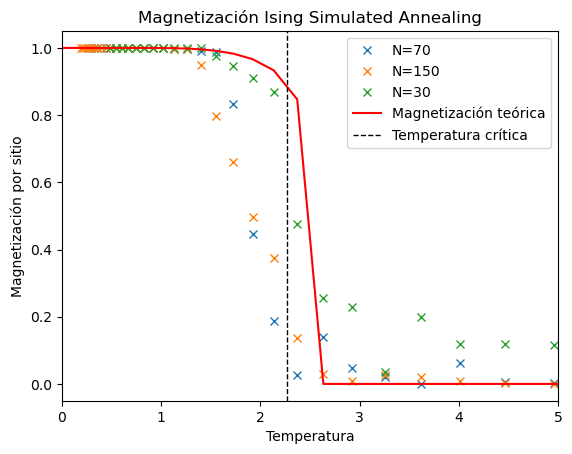

In [47]:
plt.plot(temperature[:iter_meta1+1], abs(magnetizacion_metaheuristic1), "x", label = "N=70")
plt.plot(temperature[:iter_meta2+1], abs(magnetizacion_metaheuristic2), "x", label = "N=150")
plt.plot(temperature[:iter_meta3+1], abs(magnetizacion_metaheuristic3), "x", label = "N=30")
plt.plot(temperature, real_magnetization_meta,  "-r", label = "Magnetización teórica")
plt.axvline(critic_temperature, ls = "--", c="k", lw = 1.,label ="Temperatura crítica")
plt.xlabel("Temperatura")
plt.ylabel("Magnetización por sitio")
plt.title("Magnetización Ising Simulated Annealing")
plt.xlim(0,5)
plt.legend()
plt.savefig("Magnetización meta.jpeg")

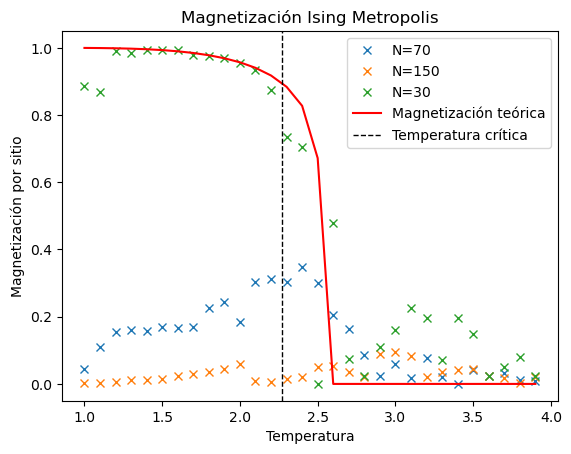

In [74]:
plt.plot(temperature_heu, abs(magnetizacion_heur1), "x", label = "N=70")
plt.plot(temperature_heu, abs(magnetizacion_heur2), "x", label = "N=150")
plt.plot(temperature_heu, abs(magnetizacion_heur3), "x", label = "N=30")
plt.plot(temperature_heu, real_magnetization_heuristic,  "-r", label = "Magnetización teórica")
plt.title("Magnetización Ising Metropolis")
plt.xlabel("Temperatura")
plt.ylabel("Magnetización por sitio")
plt.axvline(critic_temperature, ls = "--", c="k",lw = 1., label ="Temperatura crítica")

plt.legend()
plt.savefig("magnetizacion heuristico.jpeg")

--------------------------
--------------------------------
---------

In [ ]:
x0 = init()## Inicializar sistema

x01 = x0.copy()
x02 = x0.copy()

beta = 1/0.01

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

im1 = ax[0].imshow(x01, cmap='gray')
ax[0].set_title("Metropolis")

im2 = ax[1].imshow(x02, cmap='gray')
ax[1].set_title("Simulated annealing")


def update(frame):
  global x01, x02
  x01 = metropolis_total(x01 ,iteraciones=400, beta=beta)[0]
  x02 = ising_all_system_const(x02, temperature=T0, iteraciones=400, sub_iteraciones=20)[0]
  im1.set_array(x01)
  im2.set_array(x02)
  return [im1, im2]

ani = animation.FuncAnimation(fig, update, frames=400, blit=True)


In [ ]:
ani.save("punto_3.mp4")